In [ ]:
import pandas as pd
from scripts.load_data import load_data
from models.ml_optimizer import MLOptimizer

# rabi yehdik ya rakia 
# Charger données
data, prices_matrix, tx_df = load_data()
print(data)

# Créer ML optimizer avec fraction minimale 5%
optimizer = MLOptimizer(data, prices_matrix, tx_df, min_allocation=0.05)
optimizer.train_models()

# Vérifier les prédictions
data_pred = optimizer.data[["symbol", "pred_return", "pred_liquidity", "pred_risk"]]
data_pred

# Paramètres
amount_to_invest = 10000
risk_tolerance = 0.4
allowed_symbols = ["PAXG", "OMMF"]
liquidity_weight = 0.2

allocation = optimizer.optimize_portfolio(
    amount_invest=amount_to_invest,
    risk_tolerance=risk_tolerance,
    allowed_symbols=allowed_symbols,
    liquidity_weight=liquidity_weight
)

# Afficher le portefeuille optimal
allocation




  symbol  price_usd                timestamp_x        project     chain  \
0   PAXG    4210.31 2025-12-05 23:28:35.595524  fluid-lending  Ethereum   
1   XAUt    4194.01 2025-12-05 23:28:36.074710              0         0   
2   OUSG     113.54 2025-12-05 23:28:36.570907   flux-finance  Ethereum   
3   USTB       0.00 2025-12-05 23:28:36.877052              0         0   
4   OMMF       0.00 2025-12-05 23:28:37.259949              0         0   

            apy      apy_base                timestamp_y  total_supply  \
0   28470.92092   28470.92092 2025-12-05 23:51:10.964332  3.397430e+05   
1       2.00200       2.00200 2025-12-05 23:51:12.629508  5.220893e+05   
2       2.00200       2.00200 2025-12-05 23:51:06.203406  5.813952e+06   
3  294485.76713  294485.76713 2025-12-05 23:51:07.681508  5.574212e+07   
4       2.00200       2.00200 2025-12-05 23:51:09.232975  2.000000e-18   

                   timestamp  total_volume  tx_count  
0 2025-12-05 23:51:10.964332  3.397430e+05       

{'PAXG': np.float64(50.0), 'OMMF': np.float64(50.0)}

=== Aperçu des assets ===
  symbol  price_usd                timestamp_x        project     chain  \
0   PAXG    4210.31 2025-12-05 23:28:35.595524  fluid-lending  Ethereum   
1   XAUt    4194.01 2025-12-05 23:28:36.074710              0         0   
2   OUSG     113.54 2025-12-05 23:28:36.570907   flux-finance  Ethereum   
3   USTB       0.00 2025-12-05 23:28:36.877052              0         0   
4   OMMF       0.00 2025-12-05 23:28:37.259949              0         0   

            apy      apy_base                timestamp_y  total_supply  \
0   28470.92092   28470.92092 2025-12-05 23:51:10.964332  3.397430e+05   
1       2.00200       2.00200 2025-12-05 23:51:12.629508  5.220893e+05   
2       2.00200       2.00200 2025-12-05 23:51:06.203406  5.813952e+06   
3  294485.76713  294485.76713 2025-12-05 23:51:07.681508  5.574212e+07   
4       2.00200       2.00200 2025-12-05 23:51:09.232975  2.000000e-18   

                   timestamp  total_volume  tx_count  
0 2025-12-05 23:51:10.9

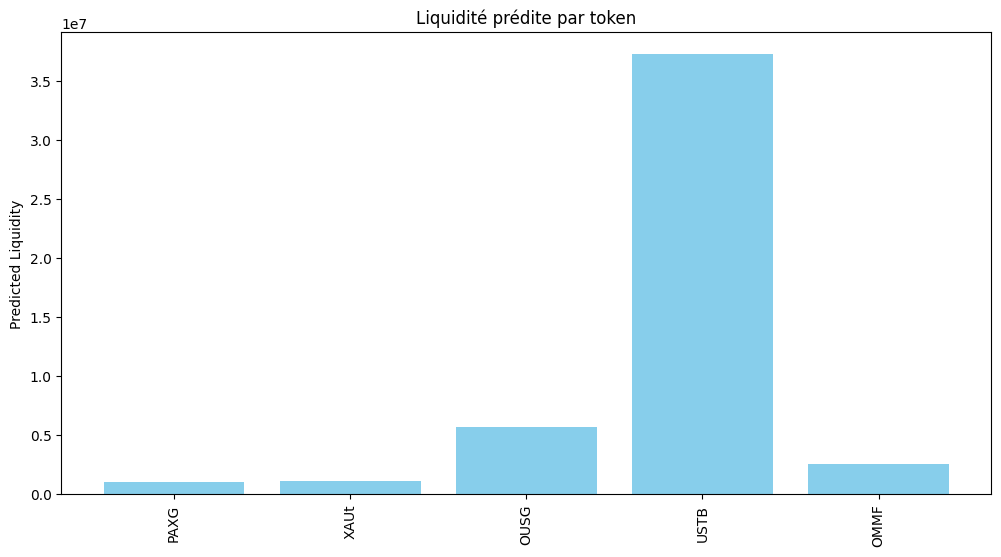

Symbols dans data : {'OUSG', 'OMMF', 'XAUt', 'USTB', 'PAXG'}
Symbols dans tx_df : {'OUSG', 'OMMF', 'XAUt', 'USTB', 'PAXG'}


In [7]:
# ===============================
# Notebook : Vérification Liquidité
# ===============================

# 1️⃣ Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Charger les données depuis ton script
from scripts.load_data import load_data

# ===============================
# 2️⃣ Charger les données
# ===============================
data, prices_matrix, tx_df = load_data()

print("=== Aperçu des assets ===")
print(data.head())

print("\n=== Aperçu des transactions ===")
print(tx_df.head())

# ===============================
# 3️⃣ Préparer les features
# ===============================
# Rendements journaliers
daily_returns = prices_matrix.pct_change().dropna()
data["hist_volatility"] = data["symbol"].map(daily_returns.std())
data["hist_return"] = data["symbol"].map(daily_returns.mean())

# Transaction features
if tx_df is not None and not tx_df.empty:
    tx_features = tx_df.groupby("symbol").agg(
        total_volume=("value", "sum"),
        tx_count=("txhash", "count")
    ).reset_index()
    data = data.merge(tx_features, on="symbol", how="left")

# Gérer le merge correct pour éviter overwrite
# Si merge crée total_volume_x et total_volume_y
for col in ["total_volume", "tx_count"]:
    if f"{col}_y" in data.columns:
        data[col] = data[f"{col}_y"].fillna(data[f"{col}_x"].fillna(0))
        # Supprimer les colonnes intermédiaires
        data = data.drop(columns=[f"{col}_x", f"{col}_y"])
    else:
        # Sinon juste remplir les NaN
        data[col] = data[col].fillna(0)

# fallback pour expected_return
if "expected_return" not in data.columns:
    data["expected_return"] = data["hist_return"].fillna(0)

print("\n=== Aperçu après préparation ===")
print(data[["symbol","total_volume","tx_count","hist_volatility","hist_return","expected_return"]].head())

# ===============================
# 4️⃣ Entraîner modèles ML
# ===============================
feature_cols = ["hist_return", "hist_volatility", "total_supply", "total_volume", "tx_count"]
X = data[feature_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Rendement
y_return = data["expected_return"].fillna(0)
model_return = RandomForestRegressor(n_estimators=100, random_state=42)
model_return.fit(X_scaled, y_return)
data["pred_return"] = model_return.predict(X_scaled)

# Liquidité
y_liquidity = data["total_volume"].fillna(0)
model_liquidity = RandomForestRegressor(n_estimators=100, random_state=42)
model_liquidity.fit(X_scaled, y_liquidity)
data["pred_liquidity"] = model_liquidity.predict(X_scaled)

# Risque
y_risk = data["hist_volatility"].fillna(0)
model_risk = RandomForestRegressor(n_estimators=100, random_state=42)
model_risk.fit(X_scaled, y_risk)
data["pred_risk"] = model_risk.predict(X_scaled)

# ===============================
# 5️⃣ Vérifier les prédictions
# ===============================
print("\n=== Prédictions ML (triées par liquidité) ===")
display_cols = ["symbol","pred_return","pred_liquidity","pred_risk"]
print(data[display_cols].sort_values("pred_liquidity", ascending=False).head(20))

# ===============================
# 6️⃣ Graphique simple
# ===============================
plt.figure(figsize=(12,6))
plt.bar(data["symbol"], data["pred_liquidity"], color="skyblue")
plt.xticks(rotation=90)
plt.title("Liquidité prédite par token")
plt.ylabel("Predicted Liquidity")
plt.show()

# ===============================
# 7️⃣ Vérification des symbols
# ===============================
print("Symbols dans data :", set(data["symbol"]))
print("Symbols dans tx_df :", set(tx_df["symbol"]))
